In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
np.random.seed(42)

In [3]:
# #Loading Data set
# data = genfromtxt("/content/drive/My Drive/ECE657_assign1/train_data.csv", delimiter=',')
# label=genfromtxt("/content/drive/My Drive/ECE657_assign1/train_labels.csv", delimiter=',')

In [4]:
#Loading Data set
data = genfromtxt("Data/train_data.csv", delimiter=',')
label=genfromtxt("Data/train_labels.csv", delimiter=',')

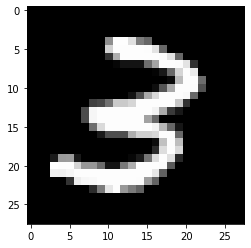

In [5]:
plt.imshow(data[1500, :].reshape((28, 28)),cmap="gray")

In [6]:
#checking the balance the dataset
print('Number of samples in each class', label.sum(axis=0))

Number of samples in each class [5923. 6742. 5958. 6131.]


In [7]:
'''
So the class0 has 5923 samples
   the class1 has 6742 samples
   the class2 has 5958 samples
   the class3 has 6131 samples
'''

'\nSo the class0 has 5923 samples\n   the class1 has 6742 samples\n   the class2 has 5958 samples\n   the class3 has 6131 samples\n'

In [8]:
#Splitting the data into training and validation set in a ratio of 8:2
#Created validation set to test the model on unknown data
train_data=data[:19800,:]
train_label=label[:19800,:]
validation_data=data[19800:,:]
validation_label=label[19800:,:]

In [9]:
#checking the balance the dataset
print('Number of samples in each class in train label', train_label.sum(axis=0))
print('Number of samples in each class in validation label', validation_label.sum(axis=0))

Number of samples in each class in train label [4721. 5453. 4748. 4878.]
Number of samples in each class in validation label [1202. 1289. 1210. 1253.]


In [10]:
'''
So number of samples for each class for train label and validation label is almost balanced.
'''

'\nSo number of samples for each class for train label and validation label is almost balanced.\n'

In [11]:
# finding out the number of samples and features in train dataset
(samples,features) = train_data.shape

In [12]:
#declaring the number of hidden layer neurons, classes, learning rate and number of epoch for the training
'''
using 25 hidden layer neurons I was getting 97% accuracy on validation set.
I increased the hidden layer to 125 to test whether I was getting 
good accuracy or not. It increased the accuracy a bit but was taking
more computation time. So I took 25 hidden layer neurons.
'''
hidden_lyr_nodes = 25 
num_classes = 4
learning_rate = 10e-5
num_epoch=300

In [13]:
# defined sigmoid function
def sigmoid_func(x):
    return 1 / (1 + np.exp(-x))
# definded the derivative of sigmoid function
def sigmoid_drv(x):
    return sigmoid_func(x) * (1 - sigmoid_func(x))
# defined softmax fucntion
def softmax_func(x):
    val = np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)
    return val
# Turned predicted data into one hot encoding
def one_hot_enc(x):
  for i in range(0,len(x)):
    x[i,x[i,:].argmax()]=1
  out = (x == 1).astype(float)
  return out
# defined a fucntion for predicting the accuracy of the model
def prediction(x,y):
  corr=0
  incorr=0
  for i in range(0,len(x)):
    if np.array_equiv(x[i,:] , y[i,:]):
      corr+=1
    else:
      incorr+=1
  accuracy=(corr/(corr+incorr))
  return accuracy

# defined a feed forward function
def fwd(inp_data, wt_hid_lyr, bias_hid_lyr,wt_out_lyr,bias_out_lyr):
    '''
    calculating the hidden weighted input for each neuron in hidden layer 
    by multiplying input with hidden weights of that neuron
    and adding the hidden bias values
    '''
    net_hidden = np.dot(inp_data, wt_hid_lyr) + bias_hid_lyr
    '''
    calculating the hidden activations using sigmoid funtion
    '''
    act_hidden = sigmoid_func(net_hidden)
    '''
    calculating the ooutput weighted input for each neuron in output layer 
    by multiplying hidden activations with output weights of that neuron
    and adding the output bias values
    '''
    net_output = np.dot(act_hidden, wt_out_lyr) + bias_out_lyr
    '''
    calculating the output activations using softmax funtion
    '''
    act_output = softmax_func(net_output)
    return act_output, act_hidden, net_hidden


def bkd(train_data, train_label, net_hidden, act_hidden, weight_output, act_output):
    '''
    Calculating the output layer error.
    Here, act_output is the predicted output.
    train_label is the original label.
    finding the derivative of the cost function with respect to 
    weights in the output layer
    '''
    cf_netHid = act_output - train_label 
    grad_bias_out = cf_netHid
    grad_wt_out = np.dot(act_hidden.T, cf_netHid)
    '''
    Calculating the hidden layer error
    finding the derivative of the cost function with respect to 
    weights in the hidden layer
    '''
    cf_actHid = np.dot(cf_netHid, weight_output.T)
    grad_wt_hid = np.dot(train_data.T, sigmoid_drv(net_hidden) * cf_actHid)
    grad_bias_hid = cf_actHid * sigmoid_drv(net_hidden)


    return grad_wt_out, grad_bias_out, grad_wt_hid, grad_bias_hid

#defined a function for weight updating
def update_weigh(weight, cost):
    if cost.shape == (features, hidden_lyr_nodes) or cost.shape == (hidden_lyr_nodes, num_classes):
        weight -= learning_rate * cost
    elif cost.shape == (samples, hidden_lyr_nodes) or cost.shape == (samples, num_classes):
        weight -= learning_rate * cost.sum(axis=0)
    return weight
def cross_ent(original_label,predict_label):
  mul=-original_label * np.log(predict_label)
  val= np.sum(mul)
  return val

I used sigmoid function as activation function of the hidden layer neurons. For the output neurons, I used softmax function. The choice of activaiton function is a design choice.

In [14]:
# Weight initialization
weight_hidden = np.random.randn(features, hidden_lyr_nodes)
bias_hidden = np.random.randn(hidden_lyr_nodes)
weight_output = np.random.randn(hidden_lyr_nodes, num_classes)
bias_output = np.random.randn(num_classes)

In [15]:
error_per_epoch = list()
epoch=0
while epoch<num_epoch:
  epoch+=1
  #forward propagation
  act_output, act_hidden, net_hidden = fwd(train_data, weight_hidden, bias_hidden, weight_output, bias_output)
  #backward propagation
  dcost_wo, dcost_bo, dcost_wh, dcost_bh = bkd(train_data, train_label, net_hidden, act_hidden, weight_output, act_output)
  #weight updating
  weight_hidden = update_weigh(weight_hidden, dcost_wh)
  bias_hidden = update_weigh(bias_hidden, dcost_bh)
  weight_output = update_weigh(weight_output, dcost_wo)
  bias_output = update_weigh(bias_output, dcost_bo)
  
  cal_loss = cross_ent(train_label,act_output)
  error_per_epoch.append(cal_loss)
  #calculating the accuracy per epoch
  y_pred, _, _ = fwd(validation_data, weight_hidden, bias_hidden, weight_output, bias_output)
  y_pred_enc=one_hot_enc(y_pred)
  acc=prediction(validation_label,y_pred_enc)
  if epoch%100==0:
    print('epoch = ',epoch,'   ','Loss function value: ', cal_loss,'accuracy = ',acc)
  

epoch =  100     Loss function value:  3921.991105759267 accuracy =  0.9418651594670973
epoch =  200     Loss function value:  2941.0681194113586 accuracy =  0.9527654420670165
epoch =  300     Loss function value:  2477.9118608769063 accuracy =  0.959628582963262


In [16]:
y_pred, _, _ = fwd(validation_data, weight_hidden, bias_hidden, weight_output, bias_output)
y_pred

array([[1.24001254e-04, 1.58635648e-04, 9.99510327e-01, 2.07035836e-04],
       [8.48189222e-05, 6.82236175e-04, 1.12707698e-02, 9.87962175e-01],
       [9.99624582e-01, 1.04484670e-06, 1.74432013e-04, 1.99941394e-04],
       ...,
       [1.95069251e-03, 1.07223415e-05, 9.97016605e-01, 1.02198014e-03],
       [9.61540435e-07, 9.93754584e-01, 3.62989564e-03, 2.61455904e-03],
       [8.94508734e-05, 8.63997483e-04, 5.28505794e-03, 9.93761494e-01]])

In [17]:
y_pred_enc=one_hot_enc(y_pred)

In [18]:
acc=prediction(validation_label,y_pred_enc)
print('accuracy on the validation set is ', acc*100)

accuracy on the validation set is  95.9628582963262


So the accuracy on the validation set is around 95.96%

In [19]:
np.save('Saved Weights/weight_hidden.npy', weight_hidden)
np.save('Saved Weights/bias_hidden.npy', bias_hidden)
np.save('Saved Weights/weight_output.npy', weight_output)
np.save('Saved Weights/bias_output.npy', bias_output)